# Convert Audio Files to Spectograms


A lot of this code is repurposed from Harvard's Applications of TinyML class. This code is edited for me needs. Please refer to the original code for guidance. I do not own this code.

A keyword spotting model is a machine learning model for identifying specific keywords or phrases within an audio clip. However, the model does not use any audio files as input themselves. The audio must be processed and properly cleaned for the to be able to train effieciently. This is process involves converting the audio files into filtered spectograms for the model to use as a convolutional network. We can begin this process by:

1. Gathering high quality data (audio in this case)

2. Converting the signals from analog to digital

3. Visualizing the data as spectograms

4. Filtering and creating MFCC's

## Install libraries

In [1]:
!pip install ffmpeg-python &> 0
!pip install tensorflow-io &> 0
!pip install python_speech_features &> 0
print("Packages Installed")

Packages Installed


The ffmpeg library is used to process and manipulate video, audio, and other multimedia files. The tensorflow library allows us to utilize machine learning and data science tools and features. The python speech features' library is used to provide common speech features such as MFCC's

## Import packages

In [2]:
# Audio Processing
from IPython.display import HTML, Audio
from scipy.io.wavfile import read as wav_read
from python_speech_features import mfcc
import ffmpeg
import librosa

# Encoding
from base64 import b64decode

# Evaluation
from google.colab.output import eval_js
import io

# Tensorflow
import tensorflow as tf
import tensorflow_io as tfio

# Data Visualization and Numercial Analysis
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Loading data
import pickle

print("Packages Imported")

Packages Imported


/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.8/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10unique_

- The majority of the packages used are for audio processing, such as scipy for loading in .WAV files. The python speech features' library calls the MFCC class for us to use. The librosa library is used for speech and audio analysis.

- The base64 library allows us to use the b64decode function to decode binary input into ASCII characters.

- Evaluation is carried out by Google Colab's eval and io allows us to manage input and output operations in unicode.

- NumPy is a standard python library used for numerical analysis and matplotlib is for creating graphs/charts. The cm class from Matplotlib is for building confusion matrices. Seaborn in a data visualization library used for making nicer graphs.

- Finally, pickle is just used to load data into the notebook, read and writing the data we want to.

## Define the Audio Importing Function

In [3]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

print("Chrome Audio Recorder Defined")

Chrome Audio Recorder Defined


This code allows us to access Chrome's audio recorder to access the microphone directly. This way we can record our audio directly.

## Record audio files

We need to record audio files for our keywords so our spectograms can be created. However, each keyword should be spoken loudly and quietly so the model can utilize both comparisons.

In [4]:
audio_yes_loud, sr_yes_loud = get_audio()
print("DONE")

DONE


In [5]:
audio_yes_quiet, sr_yes_quiet = get_audio()
print("DONE")

DONE


In [6]:
audio_no_loud, sr_no_loud = get_audio()
print("DONE")

DONE


In [7]:
audio_no_quiet, sr_no_quiet = get_audio()
print("DONE")

DONE


## Visualize the audio

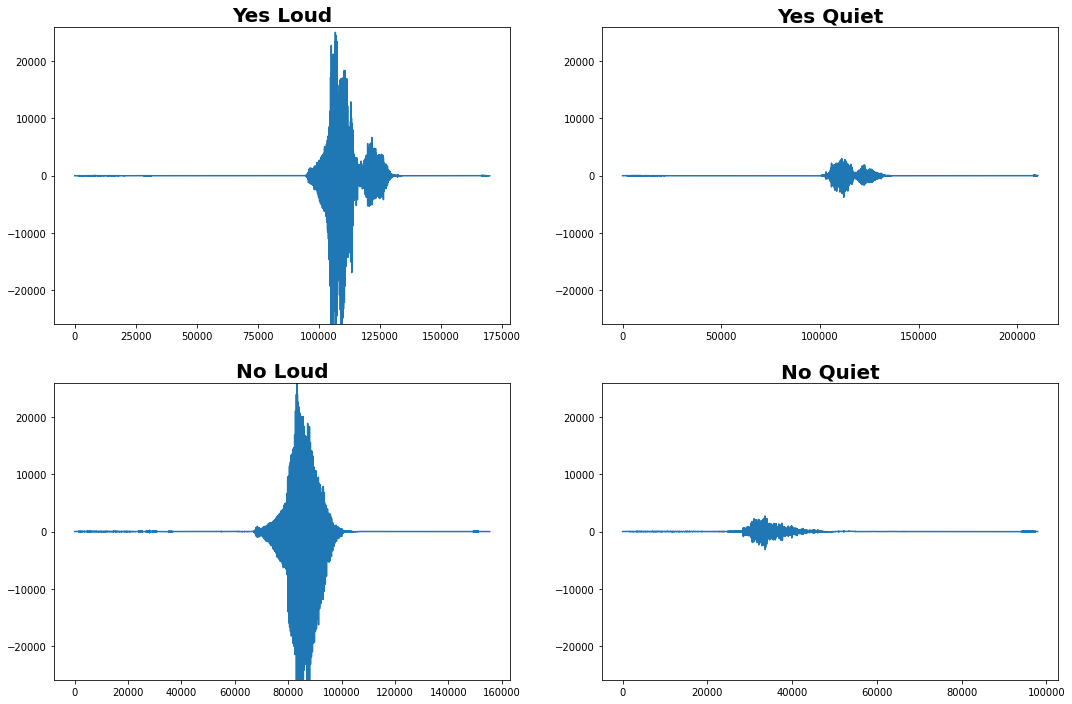

In [8]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
max_val = max(np.append(np.append(np.append(audio_yes_loud,audio_yes_quiet),audio_no_loud),audio_no_quiet))
ax1.plot(audio_yes_loud)
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(-max_val, max_val)
ax2.plot(audio_yes_quiet)
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(-max_val, max_val)
ax3.plot(audio_no_loud)
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(-max_val, max_val)
ax4.plot(audio_no_quiet)
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(-max_val, max_val)
fig.set_size_inches(18,12)

The code above converts the signal from analog to digital. 

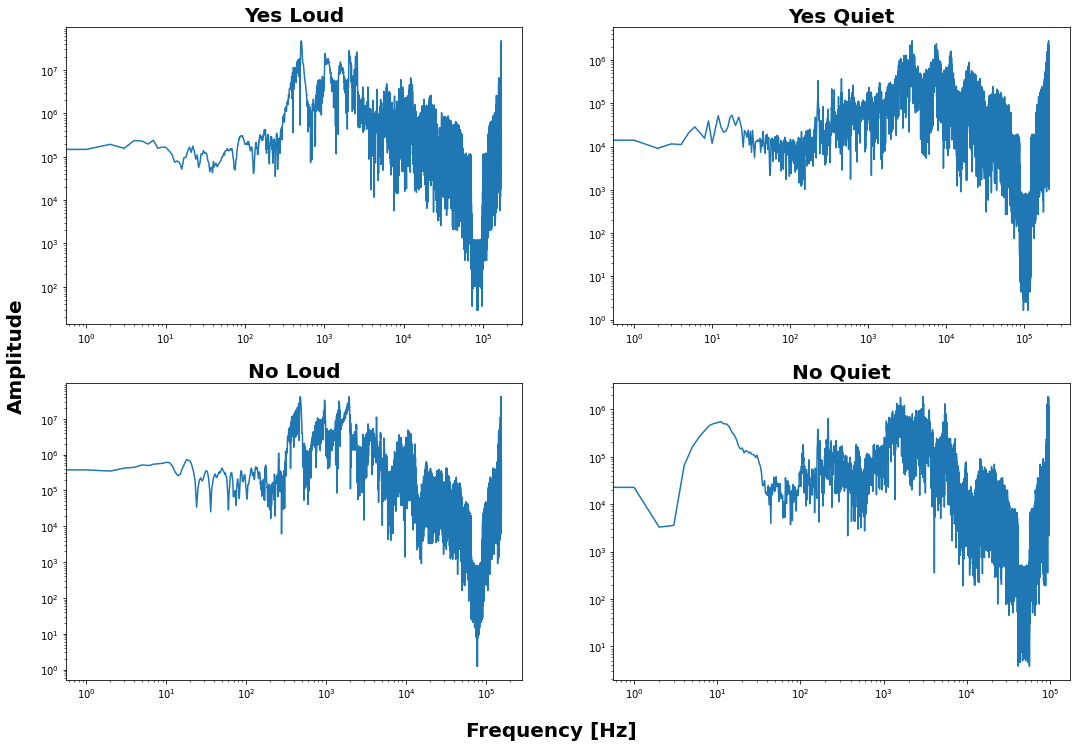

In [9]:
#Adapted from https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform
# compute the FFT and take the single-sided spectrum only and remove imaginary part
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ft_audio_yes_loud = np.abs(2*np.fft.fft(audio_yes_loud))
ft_audio_yes_quiet = np.abs(2*np.fft.fft(audio_yes_quiet))
ft_audio_no_loud = np.abs(2*np.fft.fft(audio_no_loud))
ft_audio_no_quiet = np.abs(2*np.fft.fft(audio_no_quiet))

# Plot the figure
ax1.plot(ft_audio_yes_loud)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("Yes Loud", {'fontsize':20, 'fontweight':'bold'})
ax2.plot(ft_audio_yes_quiet)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Yes Quiet", {'fontsize':20, 'fontweight':'bold'})
ax3.plot(ft_audio_no_loud)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title("No Loud", {'fontsize':20, 'fontweight':'bold'})
ax4.plot(ft_audio_no_quiet)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title("No Quiet", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)
fig.text(0.5, 0.06, 'Frequency [Hz]', {'fontsize':20, 'fontweight':'bold'}, ha='center');
fig.text(0.08, 0.5, 'Amplitude', {'fontsize':20, 'fontweight':'bold'}, va='center', rotation='vertical');

The code above applies the fourier transform to the digital signal. More on this later.

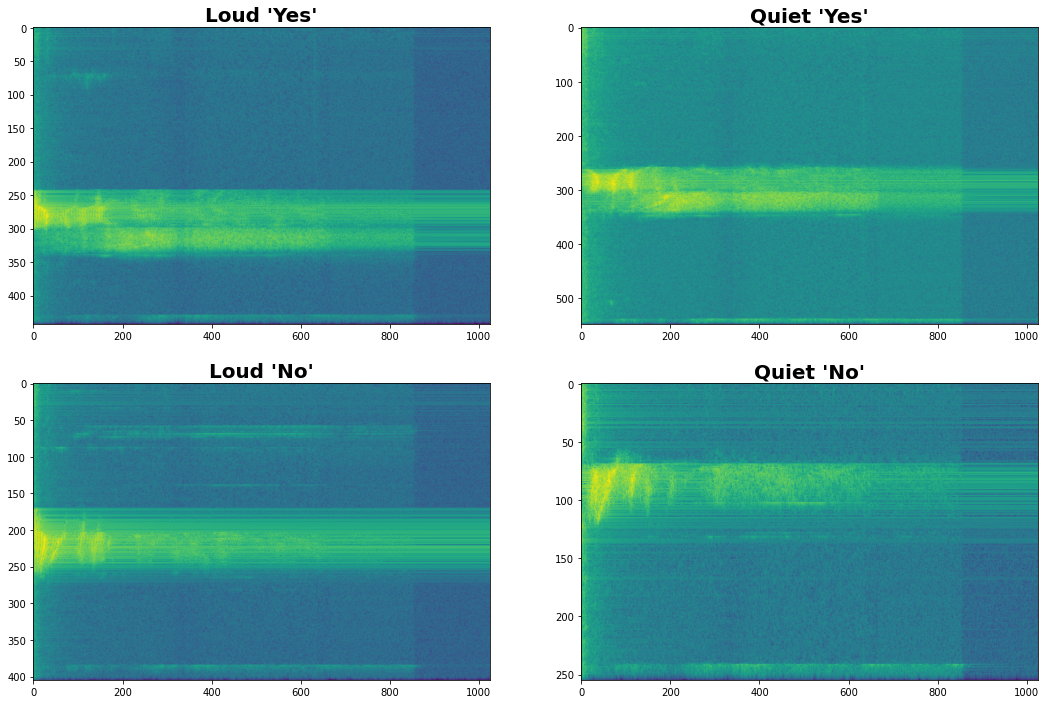

In [12]:
# Convert to spectrogram and display
# adapted from https://aruno14.medium.com/comparaison-of-audio-representation-in-tensorflow-b6c33a83d77f
spectrogram_yes_loud = tfio.audio.spectrogram(audio_yes_loud/1.0, nfft=2048, window=len(audio_yes_loud), stride=int(sr_yes_loud * 0.008))
spectrogram_yes_quiet = tfio.audio.spectrogram(audio_yes_quiet/1.0, nfft=2048, window=len(audio_yes_quiet), stride=int(sr_yes_quiet * 0.008))
spectrogram_no_loud = tfio.audio.spectrogram(audio_no_loud/1.0, nfft=2048, window=len(audio_no_loud), stride=int(sr_no_loud * 0.008))
spectrogram_no_quiet = tfio.audio.spectrogram(audio_no_quiet/1.0, nfft=2048, window=len(audio_no_quiet), stride=int(sr_no_quiet * 0.008))

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(tf.math.log(spectrogram_yes_loud).numpy(), aspect='auto')
ax1.set_title("Loud 'Yes'", {'fontsize':20, 'fontweight':'bold'})
ax2.imshow(tf.math.log(spectrogram_yes_quiet).numpy(), aspect='auto')
ax2.set_title("Quiet 'Yes'", {'fontsize':20, 'fontweight':'bold'})
ax3.imshow(tf.math.log(spectrogram_no_loud).numpy(), aspect='auto')
ax3.set_title("Loud 'No'", {'fontsize':20, 'fontweight':'bold'})
ax4.imshow(tf.math.log(spectrogram_no_quiet).numpy(), aspect='auto')
ax4.set_title("Quiet 'No'", {'fontsize':20, 'fontweight':'bold'})
fig.set_size_inches(18,12)

Spectograms are created from the signal and we can notice all kinds of background noise making our data messy

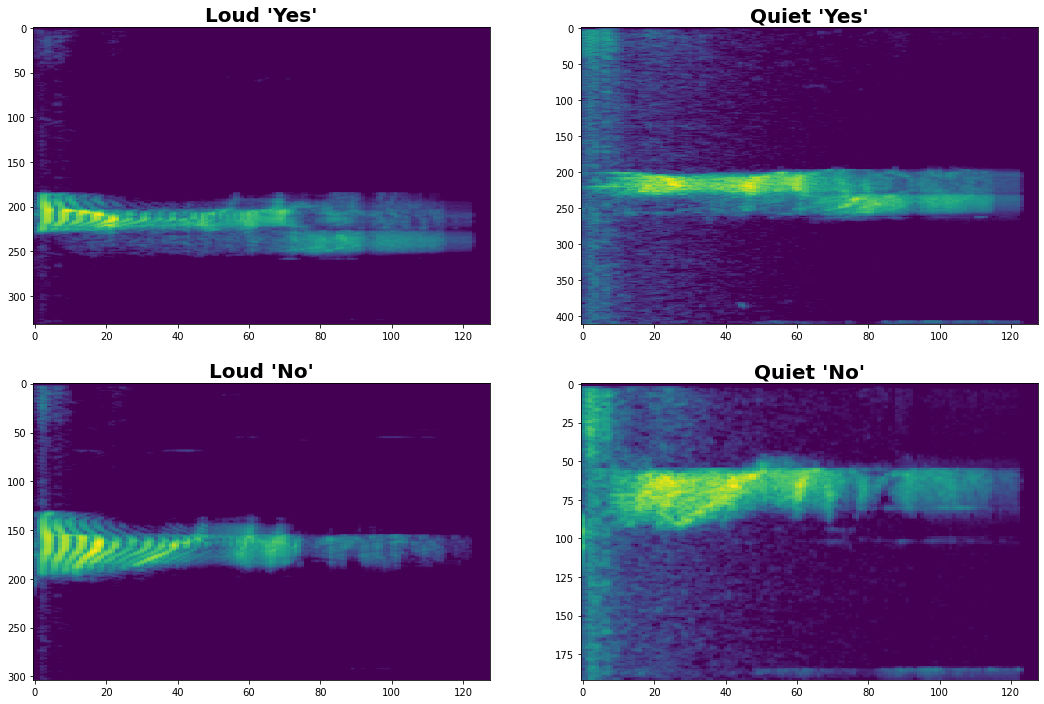

In [11]:
# Convert to MFCC using the Mel Scale
# adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
mfcc_yes_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_loud), sr=sr_yes_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_yes_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_yes_quiet), sr=sr_yes_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_loud = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_loud), sr=sr_no_loud, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
mfcc_no_quiet = librosa.power_to_db(librosa.feature.melspectrogram(
    np.float32(audio_no_quiet), sr=sr_no_quiet, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)

# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(mfcc_yes_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title("Loud 'Yes'", {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(mfcc_yes_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title("Quiet 'Yes'", {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(mfcc_no_loud, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title("Loud 'No'", {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(mfcc_no_quiet, 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title("Quiet 'No'", {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)

MFCC's are created to filter only the part of the spectogram that is useful to us. More on this later.